In [4]:
import random
import os, sys
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from preprocess import *
from preprocess_per_user import *
from stats_util import *
from graph_util import *
from outliers_util import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
year_qs = ['2012_1', '2013_1', '2014_1']
field_ys = ['pself', 'pother', 'token']
uname_info = {}
for year_q in year_qs:
    uname_info_year_q = load_uname_info(year_q)
    uname_info.update(uname_info_year_q)
uname_np = uname_info_to_array(uname_info, headers_uname)
print headers_uname

['uname', 'start_time', 'end_time', 'start_day', 'end_day', 'num_commits', 'work_hr', 'mt_abs', 'mt_rank', 'f_abs', 'f_rank', 'hss_frac', 'hss_time', 'hss_day', 'hss_token', 'hss_pother', 'ta_time', 'ta_day', 'ta_num', 'ta_hrs', 'ta_dur_num', 'ta_dur_hrs', 'ta_b4_num', 'ta_b4_hrs', 'ta_b4_mt_num', 'ta_b4_mt_hrs', 'ta_bt_exam_num', 'ta_bt_exam_hrs']


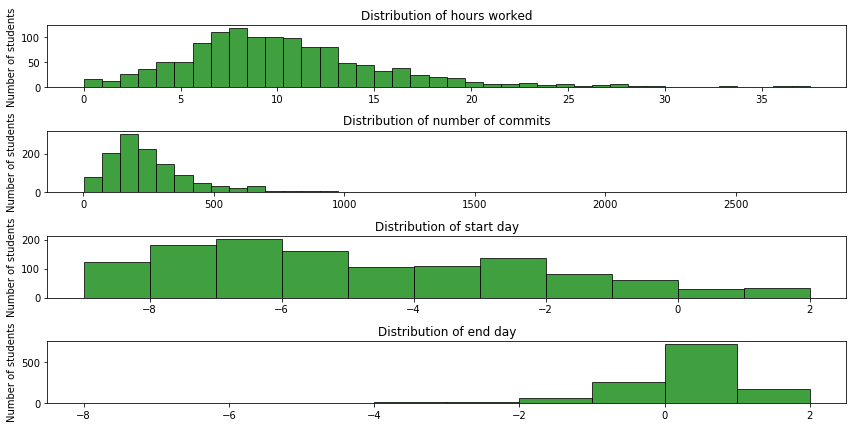

In [6]:
fig, axs = plt.subplots(4,1, figsize=(12, 6))

num_hrs = uname_np[:,get_header_uname_ind('work_hr')]
n, bins, patches = axs[0].hist(num_hrs, 40, lw=1, edgecolor='k', facecolor='green', alpha=0.75)
axs[0].set_ylabel('Number of students')
axs[0].set_title('Distribution of hours worked')

num_commits = uname_np[:,get_header_uname_ind('num_commits')]
n, bins, patches = axs[1].hist(num_commits, 40, lw=1, edgecolor='k', facecolor='green', alpha=0.75)
axs[1].set_ylabel('Number of students')
axs[1].set_title('Distribution of number of commits')

st_days = uname_np[:,get_header_uname_ind('start_day')]
n, bins, patches = axs[2].hist(st_days, 11, lw=1, edgecolor='k', facecolor='green', alpha=0.75)
axs[2].set_ylabel('Number of students')
axs[2].set_title('Distribution of start day')

end_days = uname_np[:,get_header_uname_ind('end_day')]
n, bins, patches = axs[3].hist(end_days, 10, lw=1, edgecolor='k', facecolor='green', alpha=0.75)
axs[3].set_ylabel('Number of students')
axs[3].set_title('Distribution of end day')

mt_ranks = uname_np[:,get_header_uname_ind('mt_rank')]
f_ranks = uname_np[:,get_header_uname_ind('f_rank')]
ta_hrs = uname_np[:, get_header_uname_ind('ta_hrs')]
ta_dur_hrs = uname_np[:,get_header_uname_ind('ta_dur_hrs')]

fig.tight_layout()

Average hours worked 10.1410600163


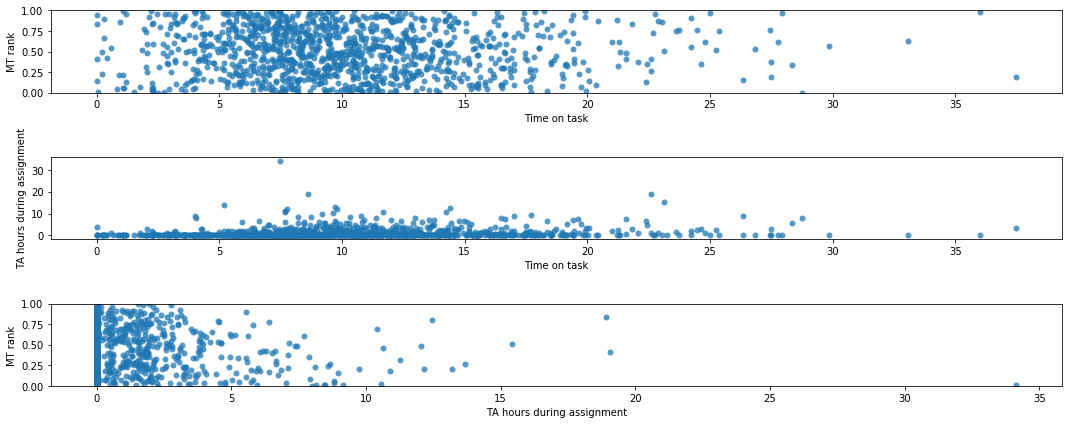

In [7]:
fig, axs = plt.subplots(3,1,figsize=(15,6))
print "Average hours worked", np.average(num_hrs)
axs[0].scatter(num_hrs, mt_ranks, alpha=0.75, lw=0)
axs[0].set_ylim((0, 1.0))
axs[0].set_xlabel('Time on task')
axs[0].set_ylabel('MT rank')

axs[1].scatter(num_hrs, ta_dur_hrs, alpha=0.75, lw=0)
axs[1].set_xlabel('Time on task')
axs[1].set_ylabel('TA hours during assignment')

axs[2].scatter(ta_dur_hrs, mt_ranks, alpha=0.75, lw=0)
axs[2].set_xlabel('TA hours during assignment')
axs[2].set_ylim((0, 1.0))
axs[2].set_ylabel('MT rank')
fig.tight_layout()

'\nprint help_diff\nhelp_range = np.arange(np.amin(help_diff), np.amax(help_diff)+1).astype(int)\nprint "range", help_range\nmt_rank_means = [np.average(mt_ranks[help_diff == i]) for i in help_range]\nmt_rank_std = [np.std(mt_ranks[help_diff==i]) for i in help_range]\naxs.scatter(help_diff, mt_ranks[used_ta])\naxs.plot(help_range, mt_rank_means, c=\'g\')\naxs.plot(help_range, mt_rank_means, yerr=mt_rank_std, fmt=\'o\', c=\'g\', alpha=0.5)\n'

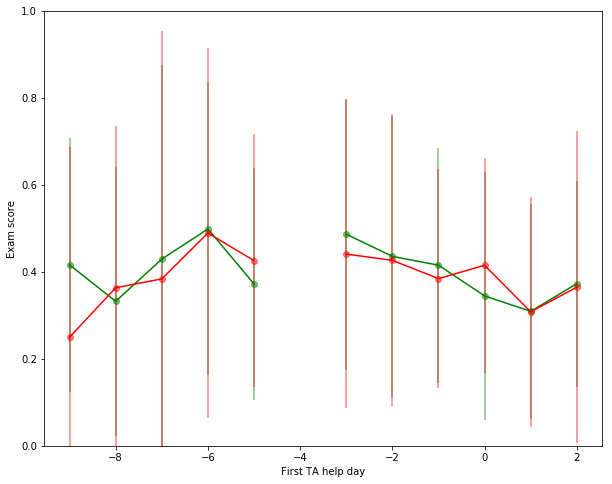

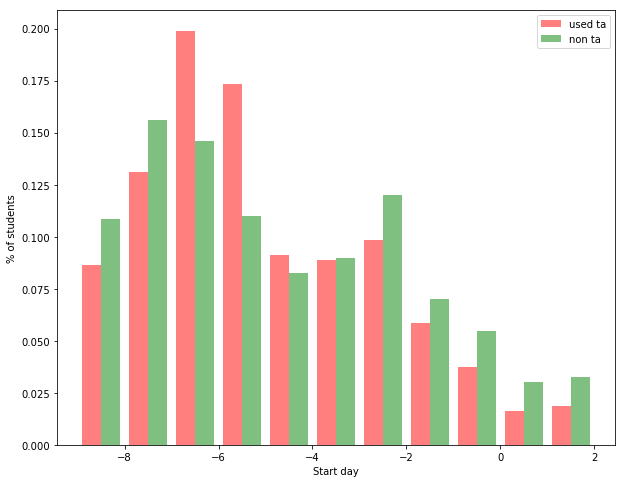

In [22]:

def get_mean_errs(days, ys, day_range=None):
    if not day_range:
        day_range = np.arange(np.amin(days[days!=nonsense_day]), np.amax(days[days!=nonsense_day])+1).astype(int)
    means = [np.average(ys[days==i]) for i in day_range]
    errs = [np.std(ys[days==i]) for i in day_range]
    return day_range, means, errs

ta_days = uname_np[:, get_header_uname_ind('ta_day')]
fig = plt.figure()
axs = plt.gca()
#axs.scatter(ta_days[ta_days!=12345], mt_ranks[ta_days!=12345], alpha=0.75, lw=0)
axs.set_ylim((0, 1.0))
ta_day_range, mt_rank_means, mt_rank_std = get_mean_errs(ta_days, mt_ranks)
axs.plot(ta_day_range, mt_rank_means, c='g')
axs.errorbar(ta_day_range, mt_rank_means, yerr=mt_rank_std, fmt='o', c='g', alpha=0.5)

ta_day_range, f_rank_means, f_rank_std = get_mean_errs(ta_days, f_ranks)
axs.plot(ta_day_range, f_rank_means, c='r')
axs.errorbar(ta_day_range, f_rank_means, yerr=f_rank_std, fmt='o', c='r', alpha=0.5)
axs.set_xlabel('First TA help day')
axs.set_ylabel('Exam score')

# difference between first day of programming vs first TA help day
fig = plt.figure()
axs = plt.ca()
used_ta = np.nonzero(ta_days!=12345)[0] # during assignment
non_ta = np.nonzero(ta_days==12345)[0] # during assignment
#used_ta = np.nonzero(ta_hrs)[0] # overall
#non_ta = np.nonzero(ta_hrs==0)[0] # overall
#help_diff = (ta_days - st_days)[used_ta]
#axs.scatter(st_days[used_ta], ta_days[used_ta])g
#axs.hist(help_diff, 20)'
#axs.hist([score_diffs[used_ta], score_diffs[non_ta]], bins=bins, alpha=0.5, color=['red', 'green'], normed=1, label=['used ta', 'non ta'])
axs.hist([st_days[used_ta], st_days[non_ta]], 11, alpha=0.5, color=['red', 'green'], normed=1, label=['used ta', 'non ta'])
#axs.hist(st_days[used_ta], 11, alpha=0.5, edgecolor='k', facecolor='r', normed=1, label='used ta')
#axs.hist(st_days[non_ta], 11, alpha=0.5, edgecolor='k', facecolor='g', normed=1, label='non ta')
axs.set_xlabel('Start day')
axs.set_ylabel('% of students')
axs.legend()
"""
print help_diff
help_range = np.arange(np.amin(help_diff), np.amax(help_diff)+1).astype(int)
print "range", help_range
mt_rank_means = [np.average(mt_ranks[help_diff == i]) for i in help_range]
mt_rank_std = [np.std(mt_ranks[help_diff==i]) for i in help_range]
axs.scatter(help_diff, mt_ranks[used_ta])
axs.plot(help_range, mt_rank_means, c='g')
axs.plot(help_range, mt_rank_means, yerr=mt_rank_std, fmt='o', c='g', alpha=0.5)
"""


mt: used ta 0.4436, no ta 0.5447
f: used ta 0.4419, no ta 0.5275
student count: used ta 414, no ta 753


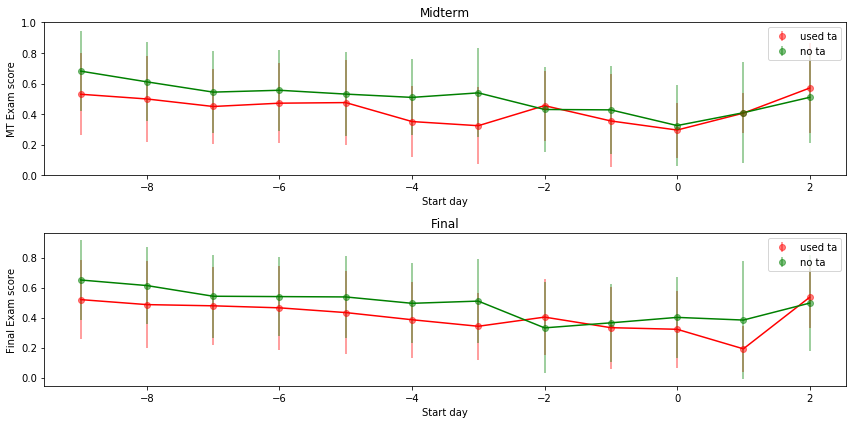

In [9]:
fig, axs = plt.subplots(2,1, figsize=(12, 6))

axs[0].set_ylim((0, 1.0))

# during assignment, took mt, took final (if they took final, they def took mt)
used_ta = np.nonzero(np.logical_and(ta_days!=12345, f_ranks!=-1))[0]
non_ta = np.nonzero(np.logical_and(ta_days==12345, f_ranks!=-1))[0]
# overall, took mt, took final
#used_ta = np.nonzero(np.logical_and(ta_hrs, f_ranks!=-1))[0]
#non_ta = np.nonzero(np.logical_and(ta_hrs==0, f_ranks!=-1))[0]
print "mt: used ta %.4f, no ta %.4f" % (np.average(mt_ranks[used_ta]), np.average(mt_ranks[non_ta]))
print "f: used ta %.4f, no ta %.4f" % (np.average(f_ranks[used_ta]), np.average(f_ranks[non_ta]))
print "student count: used ta %d, no ta %d" % (len(used_ta), len(non_ta))


# midterm
st_day_range, mt_rank_means, mt_rank_std = get_mean_errs(st_days[used_ta], mt_ranks[used_ta])
axs[0].plot(st_day_range, mt_rank_means, c='r')
axs[0].errorbar(st_day_range, mt_rank_means, yerr=mt_rank_std, fmt='o', c='r', alpha=0.5, label='used ta')
st_day_range, mt_rank_means, mt_rank_std = get_mean_errs(st_days[non_ta], mt_ranks[non_ta])
axs[0].plot(st_day_range, mt_rank_means, c='g')
axs[0].errorbar(st_day_range, mt_rank_means, yerr=mt_rank_std, fmt='o', c='g', alpha=0.5, label='no ta')
axs[0].set_xlabel('Start day')
axs[0].set_ylabel('MT Exam score')
axs[0].legend()
axs[0].set_title('Midterm')

# final
st_day_range, f_rank_means, f_rank_std = get_mean_errs(st_days[used_ta], f_ranks[used_ta])
axs[1].plot(st_day_range, f_rank_means, c='r')
axs[1].errorbar(st_day_range, f_rank_means, yerr=f_rank_std, fmt='o', c='r', alpha=0.5, label='used ta')
st_day_range, f_rank_means, f_rank_std = get_mean_errs(st_days[non_ta], f_ranks[non_ta])
axs[1].plot(st_day_range, f_rank_means, c='g')
axs[1].errorbar(st_day_range, f_rank_means, yerr=f_rank_std, fmt='o', c='g', alpha=0.5, label='no ta')
axs[1].set_xlabel('Start day')
axs[1].set_ylabel('Final Exam score')
axs[1].legend()
axs[1].set_title('Final')

fig.tight_layout()

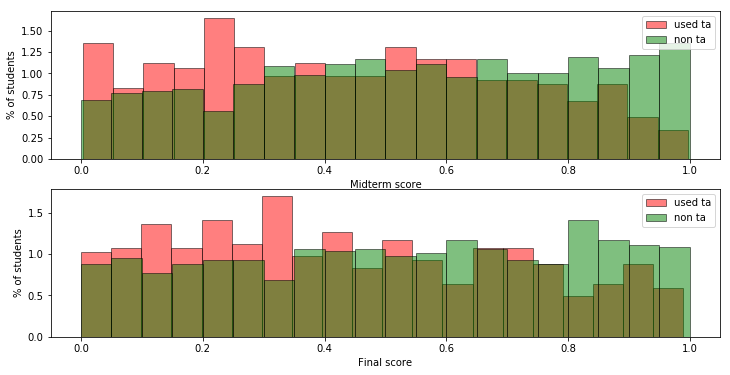

In [10]:

fig, axs = plt.subplots(2,1, figsize=(12, 6))
axs[0].hist(mt_ranks[used_ta], 20, alpha=0.5, edgecolor='k', facecolor='r', normed=1, label='used ta')
axs[0].hist(mt_ranks[non_ta], 20, alpha=0.5, edgecolor='k', facecolor='g', normed=1, label='non ta')
axs[0].set_xlabel('Midterm score')
axs[0].set_ylabel('% of students')
axs[0].legend()
axs[1].hist(f_ranks[used_ta], 20, alpha=0.5, edgecolor='k', facecolor='r', normed=1, label='used ta')
axs[1].hist(f_ranks[non_ta], 20, alpha=0.5, edgecolor='k', facecolor='g', normed=1, label='non ta')
axs[1].set_xlabel('Final score')
axs[1].set_ylabel('% of students')
axs[1].legend()


used ta with low mt score 460 no ta with low mt score 707


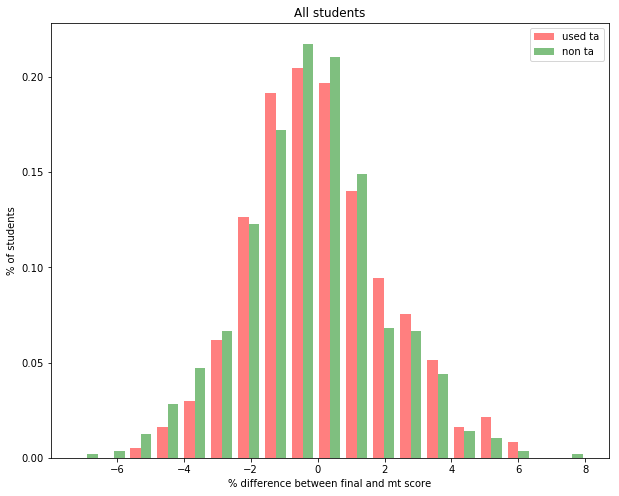

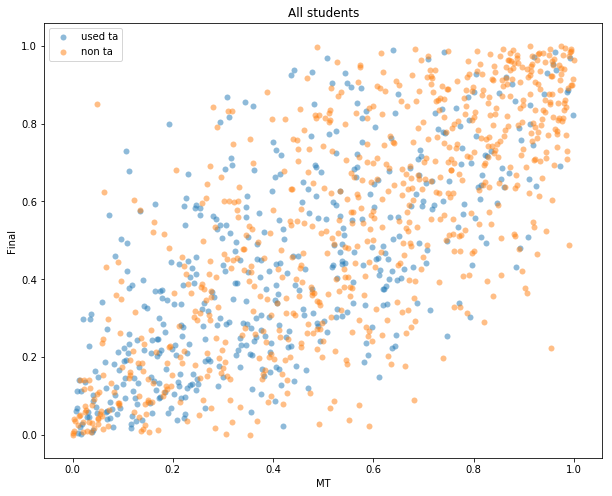

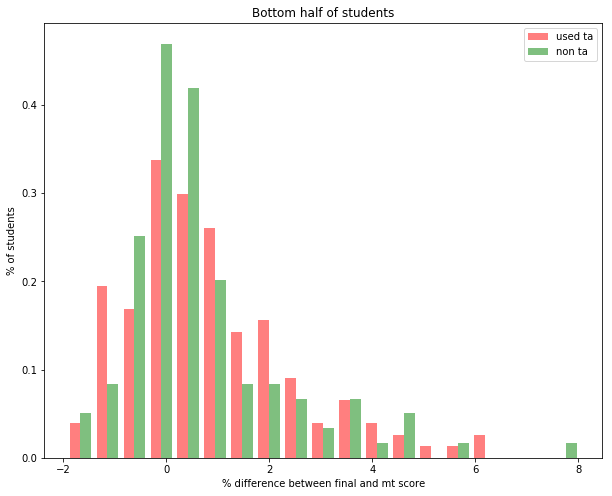

In [11]:
ta_bt_exam = uname_np[:,get_header_uname_ind('ta_bt_exam_num')]
used_ta = np.nonzero(np.logical_and(ta_bt_exam, f_ranks!=-1))[0]
non_ta = np.nonzero(np.logical_and(ta_bt_exam==0, f_ranks!=-1))[0]


fig = plt.figure()
axs = plt.gca()
score_diffs = (f_ranks - mt_ranks) *10
bins = np.linspace(np.amin(score_diffs[non_ta]), np.amax(score_diffs), num=20)
axs.hist([score_diffs[used_ta], score_diffs[non_ta]], bins=bins, alpha=0.5, color=['red', 'green'], normed=1, label=['used ta', 'non ta'])
#axs.hist(score_diffs[non_ta], bins=bins, alpha=0.5, edgecolor='k', facecolor='g', normed=1, label='non ta')
axs.set_xlabel('% difference between final and mt score')
axs.set_ylabel('% of students')
axs.legend()
axs.set_title('All students')

fig = plt.figure()
axs = plt.gca()
axs.scatter(mt_ranks[used_ta], f_ranks[used_ta], alpha=0.5, lw=0, label='used ta')
axs.scatter(mt_ranks[non_ta], f_ranks[non_ta], alpha=0.5, lw=0, label='non ta')
axs.set_xlabel('MT')
axs.set_ylabel('Final')
axs.legend()
axs.set_title('All students')



used_ta_struggle = np.nonzero(np.logical_and(np.logical_and(ta_bt_exam, f_ranks!=-1), mt_ranks<=0.25))[0]
non_ta_struggle = np.nonzero(np.logical_and(np.logical_and(ta_bt_exam==0, f_ranks!=-1), mt_ranks<0.25))[0]
print "used ta with low mt score", len(used_ta), 'no ta with low mt score', len(non_ta)

fig = plt.figure()
axs = plt.gca()
score_diffs = (f_ranks - mt_ranks) *10
bins = np.linspace(np.amin(score_diffs[non_ta_struggle]), np.amax(score_diffs), num=20)
axs.hist([score_diffs[used_ta_struggle], score_diffs[non_ta_struggle]], bins=bins, alpha=0.5, normed=1, color=['red', 'green'], label=['used ta', 'non ta'])
#axs.hist(score_diffs[non_ta], bins=bins, alpha=0.5, edgecolor='k', facecolor='g', normed=1, label='non ta')
axs.set_xlabel('% difference between final and mt score')
axs.set_ylabel('% of students')
axs.legend()
axs.set_title('Bottom half of students')



{'boxes': [<matplotlib.lines.Line2D at 0x10247e150>,
 'caps': [<matplotlib.lines.Line2D at 0x10f1da210>,
 'fliers': [<matplotlib.lines.Line2D at 0x10f1e6cd0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10f1e6290>,
 'whiskers': [<matplotlib.lines.Line2D at 0x10f1da490>,
  <matplotlib.lines.Line2D at 0x10f378a90>]}

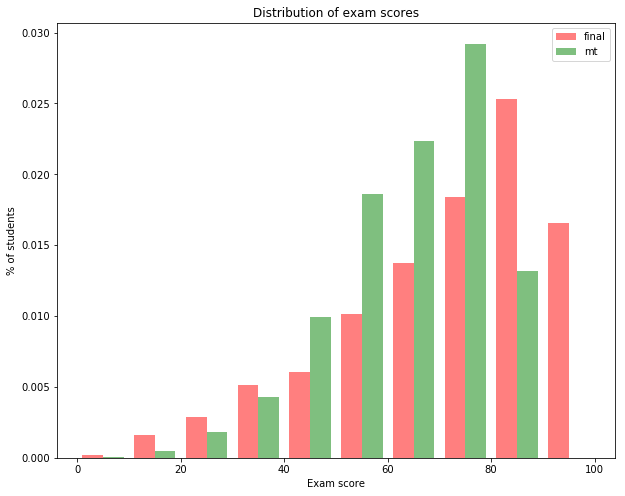

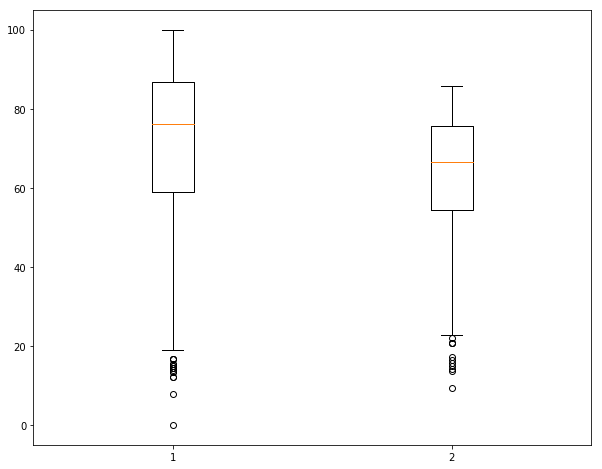

In [12]:
f_abs = uname_np[:,get_header_uname_ind('f_abs')]
mt_abs = uname_np[:,get_header_uname_ind('mt_abs')]
fig = plt.figure()
axs = plt.gca()
axs.hist([100*f_abs[f_ranks!=-1], 100*mt_abs[f_ranks!=-1]], bins=10, alpha=0.5, normed=1, color=['red', 'green'], label=['final', 'mt'])
axs.set_xlabel('Exam score')
axs.set_ylabel('% of students')
axs.legend()
axs.set_title('Distribution of exam scores')

fig = plt.figure()
axs = plt.gca()
axs.boxplot([100*f_abs[f_ranks!=-1], 100*mt_abs[f_ranks!=-1]])

# HSS analysis

[ 0.3046875   0.75        1.          0.22641509  0.00881057  0.29869067
  0.0035461   1.          0.01818182  0.67973856  0.91111111  0.18181818
  0.24630542  0.5648415   0.04385965  1.          0.00357143  0.20229008
  0.75581395  0.06802721  0.63976945  0.86956522  0.00729927  0.00843882
  1.          0.96875     0.00900901  0.04945055  0.07777778  0.20679012
  0.78508772  1.          0.0042735   1.          0.16455696  0.28682171
  0.06341463  0.02766798  0.20754717  0.0097561   0.01612903  0.84313725
  0.64497041  0.05882353  0.01639344  0.26153846  0.02586207  0.71372549
  0.01219512  0.49367089  0.00867052  0.1954023   0.17541229  0.02362205
  0.03888889  0.05555556  0.91463415  0.09090909  0.02477477  0.07027027
  0.296875    0.00884956  0.00610998  0.9929078   0.54726368  0.01639344
  0.00271003  0.04545455  0.00601202  0.00110865  0.00763359  0.00502513
  0.7265625   0.00660066  0.01033592  0.0511811   0.06557377  0.12765957
  0.52941176  0.53361345  0.375       0.00638298  0

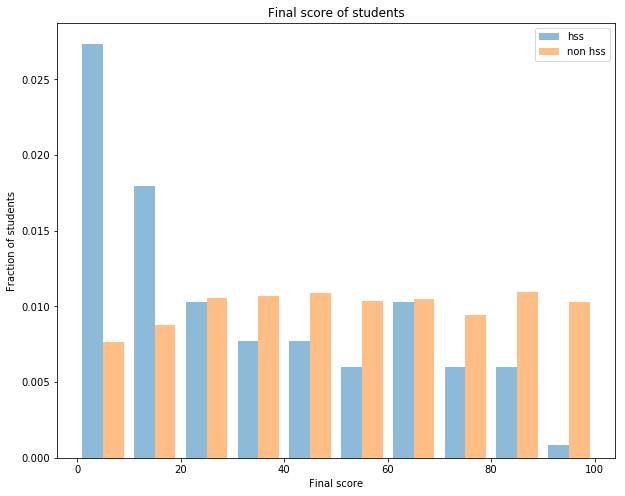

In [13]:
hss_fracs = uname_np[:,get_header_uname_ind('hss_frac')]
hss_true = np.nonzero(np.logical_and(f_ranks!=-1,hss_fracs))
print hss_fracs[hss_true]
hss_false = np.nonzero(np.logical_and(f_ranks!=-1, hss_fracs == 0))
fig = plt.figure()
axs = plt.gca()
axs.hist([f_ranks[hss_true]*100, f_ranks[hss_false]*100], bins=10, alpha=0.5, normed=1, label=['hss', 'non hss'])
axs.set_xlabel('Final score')
axs.set_ylabel('Fraction of students')
axs.legend()
axs.set_title('Final score of students')

#### Analysis
The non-HSS group is relatively uniform in exam rank distribution. On the other hand, we can see the HSS group is skewed, with a larger fraction performing below the 50th percentile.

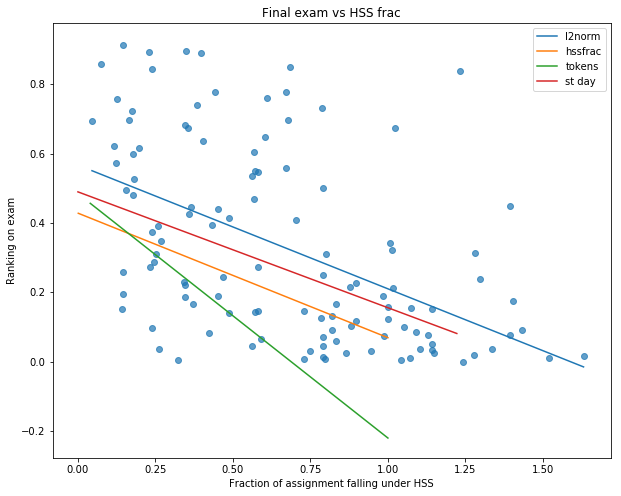

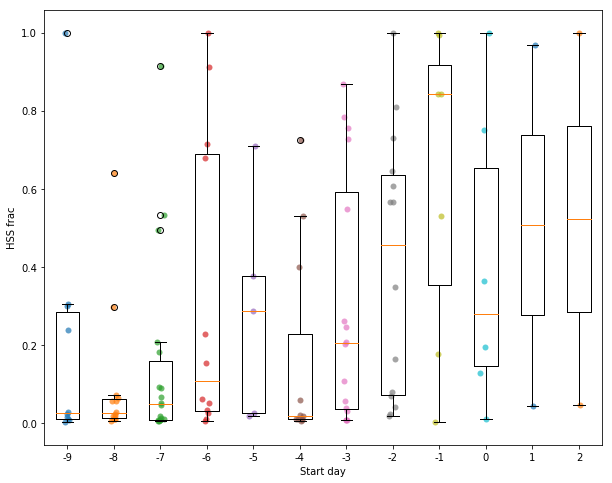

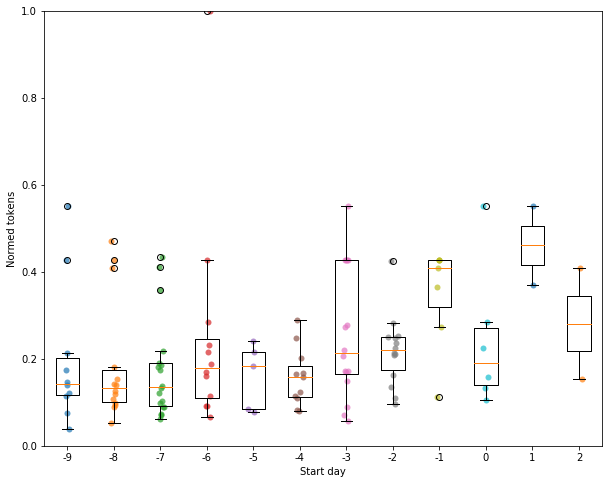

In [17]:
hss_tokens = uname_np[:,get_header_uname_ind('hss_token')]
normed_tokens = hss_tokens[hss_true]/np.amax(hss_tokens[hss_true])
#print normed_tokens
reg_num_days = - np.amin(st_days)
true_fracs = hss_fracs[hss_true]
normed_st_days = (st_days[hss_true]+reg_num_days)/reg_num_days
rgba_cols = np.zeros((len(normed_tokens),4))
rgba_cols[:,2:] = 1.0
rgba_cols[:,3] = normed_tokens
temp_arr = np.array([true_fracs, normed_tokens, normed_st_days])
x_l2 = np.linalg.norm(temp_arr,axis=0)
y = f_ranks[hss_true]


from scipy.stats import linregress
stuff = linregress(x_l2, y)
#print stuff
m, b = stuff.slope, stuff.intercept
fit = np.polyfit(x_l2, y, 1)
fit_fn = np.poly1d((m,b))

fig = plt.figure()
axs = plt.gca()
axs.scatter(x_l2, y, alpha=0.7)
axs.plot(np.sort(x_l2), fit_fn(np.sort(x_l2)), label='l2norm')

for x_l2, label in zip([true_fracs, normed_tokens ,normed_st_days],
                       ['hssfrac', 'tokens', 'st day']):
    stuff = linregress(x_l2, y)
    m, b = stuff.slope, stuff.intercept
    fit = np.polyfit(x_l2, y, 1)
    fit_fn = np.poly1d((m,b))
    axs.plot(np.sort(x_l2), fit_fn(np.sort(x_l2)), label=label)

from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(temp_arr.T, y)
#print regr.coef_
#print "mse", np.mean((regr.predict(temp_arr.T) - y) ** 2)
#print "variance score", regr.score(temp_arr.T, y)
#axs.plot(np.sort(x_l2), regr.predict(temp_arr[:,np.argsort(x_l2)].T), label='multiple linear regression')



axs.set_xlabel('Fraction of assignment falling under HSS')
axs.set_ylabel('Ranking on exam')
axs.set_title('Final exam vs HSS frac')
axs.legend()


fig = plt.figure()
axs = plt.gca()
points = []
sorted_days = sorted(np.unique(st_days).astype(int).tolist())
for i, day in enumerate(sorted_days):
    arr = true_fracs[st_days[hss_true] == day]
    points.append(arr)
    axs.scatter(np.random.normal(i+1, 0.04, size=arr.shape[0]), arr, lw=0, alpha=0.7)
axs.boxplot(points,labels=sorted_days)
axs.set_xlabel('Start day')
axs.set_ylabel('HSS frac')
plt.show()


fig = plt.figure()
axs = plt.gca()
points = []
sorted_days = sorted(np.unique(st_days).astype(int).tolist())
for i, day in enumerate(sorted_days):
    arr = normed_tokens[st_days[hss_true]== day]
    points.append(arr)
    axs.scatter(np.random.normal(i+1, 0.04, size=arr.shape[0]), arr, lw=0, alpha=0.7)
    axs.set_ylim((0, 1))
axs.boxplot(points,labels=sorted_days)
axs.set_xlabel('Start day')
axs.set_ylabel('Normed tokens')
plt.show()


>> hssfrac
-0.774174908543 -1.17219071712
mse 7.38326734761 7.17460297224
p [ 0.5438966] [ 0.01172393]
variance score 0.00575976982392 0.00158401067685
>> tokens
-0.783922128947 -1.50305104236
mse 7.44325979517 7.30350523039
p [ 0.75654012] [ 0.28624407]
variance score -0.00231888994286 -0.0163539959414
>> st day
-0.431577181208 -1.59927605757
mse 7.7839838235 6.52833546095
p [ 0.53418201] [  1.62457336e-09]
variance score -0.048201223659 0.0915184389859
>> first hss
-0.253814693878 -0.98403276131
mse 7.63260797493 6.86714658054
p [ 0.61740458] [  2.84484902e-09]
variance score -0.0278167581581 0.0443695667103


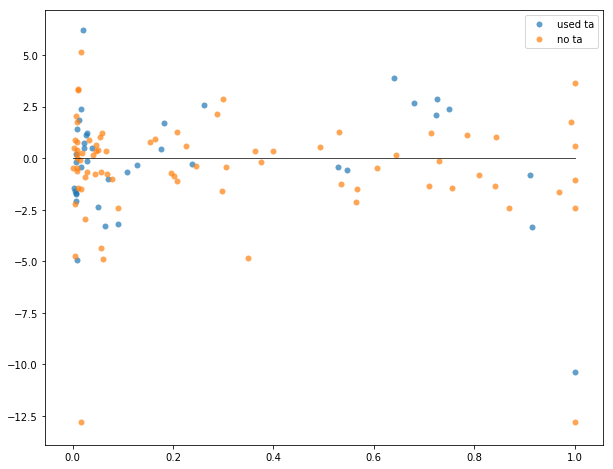

In [18]:
fig = plt.figure()
axs = plt.gca()
ta_bt_exam = uname_np[:,get_header_uname_ind('ta_bt_exam_num')][hss_true]
ta_hrs = uname_np[:,get_header_uname_ind('ta_hrs')][hss_true]

reg_num_days = - np.amin(st_days)
hss_days = uname_np[:,get_header_uname_ind('hss_day')]
normed_hss_days = (hss_days[hss_true]+reg_num_days)/reg_num_days

#x_l2 = np.linalg.norm(temp_arr,axis=0)
x_l2 = true_fracs
score_diffs = ((f_ranks - mt_ranks) *10)
#axs.scatter(x_l2, y, lw=0, alpha=0.7, label='l2norm')
#pos_diff_used_ta=np.nonzero(np.logical_and(score_diffs>0, ta_bt_exam))[0]
#neg_diff_used_ta=np.nonzero(np.logical_and(score_diffs<=0, ta_bt_exam))[0]
#pos_diff_no_ta=np.nonzero(np.logical_and(score_diffs>0, ta_bt_exam==0))[0]
#neg_diff_no_ta=np.nonzero(np.logical_and(score_diffs<=0, ta_bt_exam==0))[0]
used_ta = np.nonzero(ta_bt_exam)[0]
no_ta = np.nonzero(ta_bt_exam==0)[0]
axs.scatter(x_l2[used_ta], score_diffs[used_ta], lw=0, alpha=0.7, label='used ta')
axs.scatter(x_l2[no_ta], score_diffs[no_ta], lw=0, alpha=0.7, label='no ta')
axs.plot([0.0, 1.0], [0.0, 0.0], color='k', alpha=0.7, lw=1)
axs.legend()
#axs.scatter(x_l2[pos_diff_used_ta], score_diffs[pos_diff_used_ta], lw=0, alpha=0.7, label='diff>0/ta')
#axs.scatter(x_l2[neg_diff_used_ta], y[neg_diff_used_ta], lw=0, alpha=0.7, label='diff<=0/ta')
#axs.scatter(x_l2[pos_diff_no_ta], score_diffs[pos_diff_no_ta], lw=0, alpha=0.7, label='diff>0/no')
#axs.scatter(x_l2[neg_diff_no_ta], y[neg_diff_no_ta], lw=0, alpha=0.7, label='diff<=0/no')

from scipy import stats
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        #se = np.array([
        #    np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
        #                                            for i in range(sse.shape[0])
        #            ])
        se = np.array(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self
    
for temp_x, label in zip([true_fracs, normed_tokens ,normed_st_days, normed_hss_days],
                       ['hssfrac', 'tokens', 'st day', 'first hss']):
    temp_x, y = np.transpose(np.matrix(temp_x)), score_diffs
    print ">>", label
    regr = LinearRegression()
    regr.fit(temp_x[used_ta], y[used_ta])
    with_ta, with_t, with_p = regr.coef_[0], regr.t, regr.p
    regr.fit(temp_x[no_ta], y[no_ta])
    wo_ta, wo_t, wo_p = regr.coef_[0], regr.t, regr.p
    print with_ta, wo_ta
    print "mse", np.mean((regr.predict(temp_x[used_ta]) - y[used_ta]) ** 2), np.mean((regr.predict(temp_x[no_ta]) - y[no_ta]) ** 2)
    print "p", with_p, wo_p
    print "variance score", regr.score(temp_x[used_ta], y[used_ta]), regr.score(temp_x[no_ta], y[no_ta])

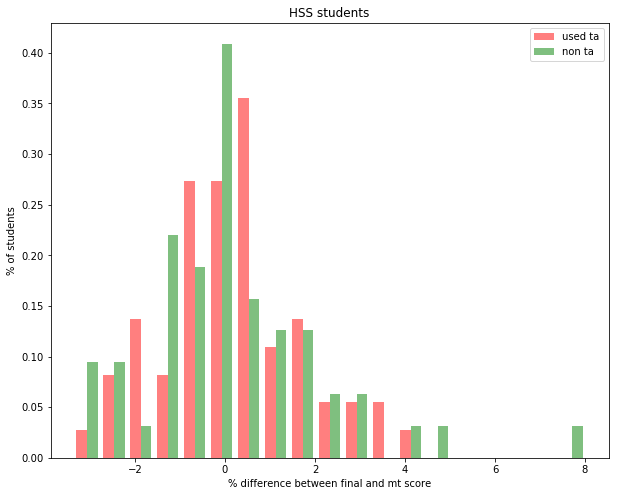

In [19]:
ta_bt_exam_hss = uname_np[:,get_header_uname_ind('ta_bt_exam_num')][hss_true]
ta_hrs_hss = uname_np[:,get_header_uname_ind('ta_hrs')][hss_true]
f_ranks = uname_np[:,get_header_uname_ind('f_rank')]
mt_ranks = uname_np[:,get_header_uname_ind('mt_rank')]
f_ranks_hss, mt_ranks_hss = f_ranks[hss_true], mt_ranks[hss_true]


reg_num_days = - np.amin(st_days)
hss_days = uname_np[:,get_header_uname_ind('hss_day')]
normed_hss_days = (hss_days[hss_true]+reg_num_days)/reg_num_days

used_ta = np.nonzero(np.logical_and(ta_hrs_hss, f_ranks_hss!=-1))[0]
non_ta = np.nonzero(np.logical_and(ta_hrs_hss==0, f_ranks_hss!=-1))[0]


fig = plt.figure()
axs = plt.gca()
score_diffs = ((f_ranks_hss - mt_ranks_hss) *10)
bins = np.linspace(np.amin(score_diffs[non_ta]), np.amax(score_diffs), num=20)
axs.hist([score_diffs[used_ta], score_diffs[non_ta]], bins=bins, alpha=0.5, color=['red', 'green'], normed=1, label=['used ta', 'non ta'])
#bins = np.linspace(0, 1, num=10)
#axs.hist([normed_hss_days[used_ta], normed_hss_days[non_ta]], bins=bins, normed=1,  alpha=0.5, color=['red', 'green'],label=['used ta', 'non ta'])
axs.set_xlabel('% difference between final and mt score')
axs.set_ylabel('% of students')
axs.legend()
axs.set_title('HSS students')